Notes on code: 
 - Copy and paste all files from the Reference Data folder to the folder containing Bulk Data for the code to run
 - Machine learning model works well and at a decent run time up until section 4.3. Section 4.4 and 4.5 takes significantly more time - in the 3-4 hour range when doing cross validation - and did not output a good accuracy score. 
 - Hypothetical route case (Section 5) could only be used using a random forest model that was trained using all features, not the one with reduced dimensionality
 - Export to file (Section 6) is also compatible only with random forest models that were trained using all features. 

In [1]:
import pandas as pd
import numpy as np

In [2]:
pd.set_option('display.max_rows', 80)
pd.set_option('display.max_columns', 80)

# 1. Reference Data

In [3]:
bus_megastops = pd.read_csv('bus_megastops.csv') #this is all the bus megastops
rail_megastops = pd.read_csv('RailMegaStops.csv') #all rail megastops
m_bg = pd.read_csv('megastops_to_block_groups.csv')[['MEGA_STOP_', 'ROUTE', 'GEOID']].rename(columns={'MEGA_STOP_':'MEGASTOP_ID'}) # maps each megastops to a block group (GEOID), hard assignment
m_bg_soft = pd.read_csv('megastops_in_bg_soft.csv') # maps each megastops to a block group (GEOID), soft assignment
m_zip = pd.read_csv('megastops_to_zipcodes.csv')[['MEGA_STOP_', 'ROUTE', 'ZCTA5CE10']].rename(columns={'MEGA_STOP_':'MEGASTOP_ID', 'ZCTA5CE10':'ZIPCODE'}) # maps each megastop to a Zipcode
count_m_bg = pd.read_csv('number_of_megastops_in_each_block_group.csv')[['GEOID','NUMPOINTS']].rename(columns={'NUMPOINTS':'COUNTS'}) # counts the number of megastop in each block group 
count_m_zip = pd.read_csv('number_of_megastops_in_zipcodes.csv')[['ZCTA5CE10', 'COUNTS']].rename(columns={'ZCTA5CE10':'ZIPCODE'}) # count of the number of megastops in each zipcode
railms_in_bg = pd.read_csv('railm_in_bg_hard.csv') # counts the number of railstops in each GEOID, hard assignment
busms_in_bg = pd.read_csv('busm_in_bg_hard.csv') #counts the number of bus stops in each GEOID, hard assignment

In [4]:
np.sort(bus_megastops.ROUTE.unique()) # shows all the bus routes in the megastops file

array([  1,   2,   3,   4,   5,   6,   8,   9,  12,  13,  15,  16,  19,
        21,  24,  25,  26,  27,  30,  32,  33,  34,  36,  37,  39,  42,
        47,  49,  50,  51,  53,  55,  56,  58,  60,  66,  67,  68,  71,
        73,  74,  75,  78,  79,  81,  82,  83,  84,  85,  86,  87,  89,
        93,  95,  99, 102, 103, 104, 107, 109, 110, 111, 114, 115, 116,
       117, 119, 120, 121, 123, 124, 125, 126, 132, 140, 141, 143, 148,
       150, 153, 155, 162, 165, 170, 172, 178, 180, 181, 183, 185, 186,
       189, 191, 192, 193, 194, 195, 196, 201, 221, 800])

## 1.1 - Megastops in each Block Group, typed (ms_in_bg_typed)

In [5]:
m_bg['IS_RAIL'] = m_bg.MEGASTOP_ID.isin(rail_megastops['MEGA_STOP_ID']) # maps the type IS_RAIL to megastops per block group, makes new column
m_bg = m_bg.merge(rail_megastops[['MEGA_STOP_ID', 'PARKNRIDE']], how='left', left_on='MEGASTOP_ID', right_on='MEGA_STOP_ID').drop(columns=['MEGA_STOP_ID']).replace(np.nan,0) # adds in a Park and Ride column
pnr_in_bg = m_bg.groupby(['GEOID'])['PARKNRIDE'].sum().reset_index().rename(columns={'GEOID': 'FIPS'}) # counts the number of Park and Ride stops in a block group

In [6]:
m_bg.head()

,MEGASTOP_ID,ROUTE,GEOID,IS_RAIL,PARKNRIDE
0,-5383,121,130890219063,False,0.0
1,-5384,121,130890219063,False,0.0
2,-5385,121,130890219063,False,0.0
3,-5386,121,130890219063,False,0.0
4,903741,121,130890219063,False,0.0


In [7]:
# creates a new dataframe shows the counts of each of the stop types (Rail, Bus, Park and Ride) in each block group
ms_in_bg_typed = pd.merge(railms_in_bg, busms_in_bg).merge(pnr_in_bg, how='left', left_on='GEOID', right_on='FIPS').drop(columns=['FIPS']).replace(np.nan, 0).astype({'PARKNRIDE': 'int'})

## 1.2 - ACS Data (Census Data) + ms_in_bg_typed (2.1)

In [8]:
allfeatures = pd.read_csv('bg_features.csv')
allfeatures['FIPS'] = allfeatures.astype({'FIPS': int})
allfeatures = allfeatures.drop(columns=['Total Population:', 'Geographic Identifier', 'Total Population:.1','Total Population:.2', 'Workers 16 Years and Over:.1', 'Workers 16 Years and Over: Worked At Home.1'])
allfeatures.fillna(allfeatures.mean(), inplace=True) #fill missing data in a column with average, need to find better model
allfeatures = allfeatures.merge(ms_in_bg_typed, how='right', left_on='FIPS', right_on='GEOID').drop(columns=['GEOID'])
allfeatures = allfeatures.rename(columns={'BUS_COUNT': 'BUS_STOP_IN_AREA', 'RAIL_COUNT': 'RAIL_STOP_IN_AREA'})
display(allfeatures.shape, allfeatures.head())

(1011, 72)

,FIPS,Total Population,Total Population: Male,Total Population: Female,Total Population: Under 5 Years,Total Population: 5 to 9 Years,Total Population: 10 to 14 Years,Total Population: 15 to 17 Years,Total Population: 18 to 24 Years,Total Population: 25 to 34 Years,Total Population: 35 to 44 Years,Total Population: 45 to 54 Years,Total Population: 55 to 64 Years,Total Population: 65 to 74 Years,Total Population: 75 to 84 Years,Total Population: 85 Years and Over,Total Population: White Alone,Total Population: Black or African American Alone,Total Population: American Indian and Alaska Native Alone,Total Population: Asian Alone,Total Population: Native Hawaiian and Other Pacific Islander Alone,Total Population: Some Other Race Alone,Total Population: Two or More Races,Average Household Size,Population 15 Years and Over:,Population 15 Years and Over: Never Married,Population 15 Years and Over: Now Married (Not Including Separated),Population 15 Years and Over: Separated,Population 15 Years and Over: Widowed,Population 15 Years and Over: Divorced,Population 25 Years and Over:,Population 25 Years and Over: Less than High School,Population 25 Years and Over: High School Graduate (Includes Equivalency),Population 25 Years and Over: Some College,Population 25 Years and Over: Bachelor's Degree,Population 25 Years and Over: Master's Degree,Population 25 Years and Over: Professional School Degree,Population 25 Years and Over: Doctorate Degree,Civilian Population in Labor Force 16 Years and Over:,Civilian Population in Labor Force 16 Years and Over: Employed,Civilian Population in Labor Force 16 Years and Over: Unemployed,Median Household Income (In 2017 Inflation Adjusted Dollars),Per Capita Income (In 2017 Inflation Adjusted Dollars),Housing Units,Workers 16 Years and Over:,"Workers 16 Years and Over: Car, Truck, or Van",Workers 16 Years and Over: Drove Alone,Workers 16 Years and Over: Carpooled,Workers 16 Years and Over: Public Transportation (Includes Taxicab),Workers 16 Years and Over: Motorcycle,Workers 16 Years and Over: Bicycle,Workers 16 Years and Over: Walked,Workers 16 Years and Over: Other Means,Workers 16 Years and Over: Worked At Home,Workers 16 Years and Over: Did Not Work At Home,Workers 16 Years and Over: Did Not Work At Home: Less than 10 Minutes,Workers 16 Years and Over: Did Not Work At Home: 10 to 19 Minutes,Workers 16 Years and Over: Did Not Work At Home: 20 to 29 Minutes,Workers 16 Years and Over: Did Not Work At Home: 30 to 39 Minutes,Workers 16 Years and Over: Did Not Work At Home: 40 to 59 Minutes,Workers 16 Years and Over: Did Not Work At Home: 60 to 89 Minutes,Workers 16 Years and Over: Did Not Work At Home: 90 or More Minutes,Renter-Occupied Housing Units,Renter-Occupied Housing Units: No Vehicle Available,Renter-Occupied Housing Units: 1 Vehicle Available,Renter-Occupied Housing Units: 2 Vehicles Available,Renter-Occupied Housing Units: 3 Vehicles Available,Renter-Occupied Housing Units: 4 Vehicles Available,Renter-Occupied Housing Units: 5 or More Vehicles Available,RAIL_STOP_IN_AREA,BUS_STOP_IN_AREA,PARKNRIDE
0,130630402021,1410,604,806,125,176,67,90,278,325,89,125,83,41,11,0,88,1294,0,2,0,21,5,2.90,1042,596,268,9,26,143,674,87,292,224,51,20,0,0,670,542,128,29280.0,12000.0,649,528,447,342,105,49,0,0,0,9,23,505,36,153,161,65,28,43,19,423,70,242,94,0,17,0,0,9,0
1,130630402022,1237,557,680,152,130,85,25,126,210,137,169,156,36,11,0,189,770,0,143,0,115,20,3.81,870,356,351,16,9,138,719,231,289,114,72,9,4,0,642,591,51,41250.0,14676.0,362,582,529,486,43,22,0,0,0,0,31,551,62,192,115,64,73,29,16,143,27,58,27,31,0,0,0,2,0
2,130630402031,878,263,615,15,93,46,54,199,104,142,108,117,0,0,0,0,856,13,0,0,0,9,2.63,724,561,36,27,21,79,471,106,181,113,35,36,0,0,518,428,90,28269.0,15292.0,402,394,297,247,50,25,0,15,0,0,57,337,9,94,103,62,53,16,0,269,27,221,21,0,0,0,0,0,0
3,130630402032,2695,1321,1374,255,203,138,86,350,490,458,376,252,79,0,8,73,2534,0,88,0,0,0,2.64,2099,1308,339,56,41,355,1663,200,507,640,230,67,0,19,1650,1305

In [9]:
allfeatures.columns

Index(['FIPS', 'Total Population', 'Total Population: Male',
       'Total Population: Female', 'Total Population: Under 5 Years',
       'Total Population: 5 to 9 Years', 'Total Population: 10 to 14 Years',
       'Total Population: 15 to 17 Years', 'Total Population: 18 to 24 Years',
       'Total Population: 25 to 34 Years', 'Total Population: 35 to 44 Years',
       'Total Population: 45 to 54 Years', 'Total Population: 55 to 64 Years',
       'Total Population: 65 to 74 Years', 'Total Population: 75 to 84 Years',
       'Total Population: 85 Years and Over', 'Total Population: White Alone',
       'Total Population: Black or African American Alone',
       'Total Population: American Indian and Alaska Native Alone',
       'Total Population: Asian Alone',
       'Total Population: Native Hawaiian and Other Pacific Islander Alone',
       'Total Population: Some Other Race Alone',
       'Total Population: Two or More Races', 'Average Household Size',
       'Population 15 Years an

# 2. Bulk Data

In [10]:
#getting all the filenames of the individual trips/apc/legs in the folder
import glob, os
fileDir = os.path.realpath('__file__')
data_path = os.path.join(fileDir, '../Final_Time_Data')
data_path = os.path.abspath(os.path.realpath(data_path))
trip_filenames = glob.glob(os.path.join(data_path,'*trips.csv'))
apc_filenames = glob.glob(os.path.join(data_path,'*apc_data.csv'))
legs_filenames = glob.glob(os.path.join(data_path,'*legs.csv'))

In [11]:
# aggregating all files into one - trips, apc, and legs
trips = pd.concat([pd.read_csv(trips) for trips in trip_filenames])
apc = pd.concat([pd.read_csv(apc) for apc in apc_filenames])
legs = pd.concat([pd.read_csv(legs) for legs in legs_filenames])

In [12]:
# resetting the index into 1, 2, 3, 4 format
trips = trips.reset_index(drop=True)
apc = apc.reset_index(drop=True)
legs = legs.reset_index(drop=True)

## 2.1 - Trips

In [13]:
trips = trips.astype({'BREEZE_ID': int})
trips['DEPARTURE_TIME'] = pd.to_datetime(trips['DEPARTURE_TIME'])
trips['ARRIVAL_TIME'] = pd.to_datetime(trips['ARRIVAL_TIME'])
trips['DAY'] = trips.DEPARTURE_TIME.dt.dayofweek
trips['DURATION'] = round((trips.ARRIVAL_TIME - trips.DEPARTURE_TIME).dt.seconds/60)

unchained_trips = trips[trips.DESTINATION.notnull()==False]
chained_trips = trips[trips.DESTINATION.notnull()]

In [14]:
print('Trips, Total Rows: ', trips.shape)
print('Unchained Trips, Total Rows: ', unchained_trips.shape)
print('Chained Trips, Total Rows: ', chained_trips.shape)

Trips, Total Rows:  (1000599, 8)
Unchained Trips, Total Rows:  (374984, 8)
Chained Trips, Total Rows:  (625615, 8)


In [15]:
trips.head()

,TRIP_ID,BREEZE_ID,ORIGIN,DESTINATION,DEPARTURE_TIME,ARRIVAL_TIME,DAY,DURATION
0,1,-2147190972,907906,906647.0,2018-01-10 05:49:09,2018-01-10 06:21:18,2,32.0
1,2,-2147190972,906647,907906.0,2018-01-10 15:11:09,2018-01-10 15:49:48,2,39.0
2,3,-2147190972,-1296,NaN,2018-01-10 16:02:36,NaT,2,NaN
3,4,-2147190972,-471,NaN,2018-01-10 21:10:26,NaT,2,NaN
4,5,-2146897676,906389,NaN,2018-01-10 09:00:19,NaT,2,NaN


### 2.1.1 - How many people use the stops?

In [16]:
trips['IS_RAIL'] = trips.ORIGIN.isin(rail_megastops['MEGA_STOP_ID']) #what is the trip type?

In [17]:
day_og_count = trips.groupby(['DAY','ORIGIN']).size().reset_index(name='COUNT')
display(day_og_count.head(), day_og_count.shape)

,DAY,ORIGIN,COUNT
0,0,-6179,66
1,0,-6175,162
2,0,-6174,140
3,0,-6167,18
4,0,-6165,76


(7642, 3)

In [18]:
display(day_og_count.COUNT.sum(), len(day_og_count.ORIGIN.unique()))

1000599

3154

In [19]:
total_riders = day_og_count.merge(m_bg, how='inner', left_on='ORIGIN', right_on='MEGASTOP_ID').groupby(['IS_RAIL','DAY', 'GEOID'])['COUNT'].sum().reset_index()
total_rail_riders = total_riders[total_riders.IS_RAIL==True].drop(columns=['IS_RAIL']).rename(columns={'COUNT': 'RAIL_RIDERS'})
total_bus_riders = total_riders[total_riders.IS_RAIL==False].drop(columns=['IS_RAIL']).rename(columns={'COUNT': 'BUS_RIDERS'})

total_riders = pd.merge(total_rail_riders, total_bus_riders, how='outer', on=['DAY', 'GEOID'])

In [20]:
len(total_riders.GEOID.unique())

718

In [21]:
total_riders.head()

,DAY,GEOID,RAIL_RIDERS,BUS_RIDERS
0,0,130639800001,4313.0,154.0
1,0,130890203003,627.0,NaN
2,0,130890212043,1315.0,348.0
3,0,130890212151,1997.0,182.0
4,0,130890213011,1899.0,131.0


### 2.1.2 - Where are people going? 

In [22]:
np.sort(trips.DEPARTURE_TIME.dt.day.unique())

array([ 1,  4,  5,  7,  9, 10, 11, 12, 13, 14, 16, 17, 19, 20, 21, 22, 23,
       24, 25, 26, 29, 31])

In [23]:
trips.groupby(['BREEZE_ID', 'ORIGIN','DESTINATION','DAY']).size().sort_values(ascending=False).reset_index(name='COUNT').head()

,BREEZE_ID,ORIGIN,DESTINATION,DAY,COUNT
0,-367950658,907913,908704.0,2,9
1,976126496,906369,908639.0,2,9
2,-2003856947,907844,906647.0,2,9
3,976126496,908639,906369.0,2,9
4,-1029724864,908475,908634.0,5,8


In [24]:
avg_trip_duration = chained_trips.groupby(['ORIGIN', 'DESTINATION'])['DURATION'].mean().round().reset_index()
# avg_trip_duration

In [25]:
avg_trip_duration.head()

,ORIGIN,DESTINATION,DURATION
0,-6179,-6183.0,248.0
1,-6179,-6178.0,43.0
2,-6179,-6175.0,44.0
3,-6179,-6174.0,133.0
4,-6179,-6169.0,74.0


In [26]:
od_trips = chained_trips.groupby(['DAY','ORIGIN','DESTINATION']).size().reset_index(name='COUNT')
display(day_og_count.head(), day_og_count.shape)

,DAY,ORIGIN,COUNT
0,0,-6179,66
1,0,-6175,162
2,0,-6174,140
3,0,-6167,18
4,0,-6165,76


(7642, 3)

In [27]:
bg_to_zip = od_trips.merge(m_bg, how='inner', left_on='ORIGIN', right_on='MEGASTOP_ID').drop(columns=['MEGASTOP_ID','ROUTE']).merge(m_zip, how='inner', left_on='DESTINATION', right_on='MEGASTOP_ID').drop(columns=['MEGASTOP_ID','ROUTE'])
bg_to_bg = od_trips.merge(m_bg, how='inner', left_on='ORIGIN', right_on='MEGASTOP_ID').drop(columns=['MEGASTOP_ID','ROUTE']).merge(m_bg, how='inner', left_on='DESTINATION', right_on='MEGASTOP_ID').drop(columns=['MEGASTOP_ID','ROUTE'])
zip_to_zip = od_trips.merge(m_zip, how='inner', left_on='ORIGIN', right_on='MEGASTOP_ID').drop(columns=['MEGASTOP_ID','ROUTE']).merge(m_zip, how='inner', left_on='DESTINATION', right_on='MEGASTOP_ID').drop(columns=['MEGASTOP_ID','ROUTE'])

In [28]:
bg_to_zip = pd.merge(bg_to_zip, avg_trip_duration, how='inner', on=['ORIGIN', 'DESTINATION'])

In [29]:
display(bg_to_zip.head(),bg_to_bg.head(),zip_to_zip.head())

,DAY,ORIGIN,DESTINATION,COUNT,GEOID,IS_RAIL,PARKNRIDE,ZIPCODE,DURATION
0,0,-6179,-6175.0,1,130890225001,False,0.0,30317,44.0
1,1,-6179,-6175.0,2,130890225001,False,0.0,30317,44.0
2,2,-6179,-6175.0,2,130890225001,False,0.0,30317,44.0
3,3,-6179,-6175.0,2,130890225001,False,0.0,30317,44.0
4,4,-6179,-6175.0,5,130890225001,False,0.0,30317,44.0


,DAY,ORIGIN,DESTINATION,COUNT,GEOID_x,IS_RAIL_x,PARKNRIDE_x,GEOID_y,IS_RAIL_y,PARKNRIDE_y
0,0,-6179,-6175.0,1,130890225001,False,0.0,130890208021,False,0.0
1,1,-6179,-6175.0,2,130890225001,False,0.0,130890208021,False,0.0
2,2,-6179,-6175.0,2,130890225001,False,0.0,130890208021,False,0.0
3,3,-6179,-6175.0,2,130890225001,False,0.0,130890208021,False,0.0
4,4,-6179,-6175.0,5,130890225001,False,0.0,130890208021,False,0.0


,DAY,ORIGIN,DESTINATION,COUNT,ZIPCODE_x,ZIPCODE_y
0,0,-6179,-6175.0,1,30030,30317
1,1,-6179,-6175.0,2,30030,30317
2,2,-6179,-6175.0,2,30030,30317
3,3,-6179,-6175.0,2,30030,30317
4,4,-6179,-6175.0,5,30030,30317


In [30]:
bg_to_zip = bg_to_zip.groupby(['DAY','GEOID', 'ZIPCODE']).agg({'COUNT':['sum'], 'DURATION':['mean']}).round().reset_index() #applying different functions to different columns
bg_to_zip.columns = bg_to_zip.columns.droplevel(1) #dropping multilayer column indexes
bg_to_zip = bg_to_zip.rename(columns={'DURATION': 'AVG_TRIP_DURATION', 'COUNT': 'TOTAL_FLOW'})
bg_to_bg = bg_to_bg.groupby(['DAY','GEOID_x', 'GEOID_y'])['COUNT'].sum().reset_index()
zip_to_zip = zip_to_zip.groupby(['DAY','ZIPCODE_x', 'ZIPCODE_y'])['COUNT'].sum().reset_index()

In [31]:
bg_to_zip.head()

,DAY,GEOID,ZIPCODE,TOTAL_FLOW,AVG_TRIP_DURATION
0,0,130630402021,30315,2,55.0
1,0,130630403031,30032,1,63.0
2,0,130630403031,30291,3,42.0
3,0,130630403031,30296,1,24.0
4,0,130630403031,30303,3,75.0


## 2.3 - APC

In [32]:
print('Dataset shape: ', apc.shape)
apc.head()

Dataset shape:  (4041430, 13)


,Unnamed: 0,ROUTE_ABBR,SERVICE_TYPE_TEXT,VECHILE_TAG,LATITUDE,LONGITUDE,BOARD,ALIGHT,ARRIVAL_TM_HM,DEPARTURE_TM_HM,BLOCK_STOP_ORDER,ROUTE_DIRECTION_NAME,MEGA_STOP_ID
0,1669652,15,Weekday,1405,33.734960,-84.285634,3,0,2018-01-29 16:26:09,2018-01-29 16:26:47,632,Northbound,-6097
1,1669653,15,Weekday,1405,33.737390,-84.287156,0,3,2018-01-29 16:27:05,2018-01-29 16:27:35,633,Northbound,-6096
2,1669654,15,Weekday,1405,33.740660,-84.288894,3,0,2018-01-29 16:29:36,2018-01-29 16:30:46,635,Northbound,-6174
3,1669655,15,Weekday,1405,33.763270,-84.292503,2,0,2018-01-29 16:36:37,2018-01-29 16:37:05,648,Northbound,-6177
4,1669656,15,Weekday,1405,33.772717,-84.294651,0,4,2018-01-29 16:39:47,2018-01-29 16:40:38,653,Northbound,-6075


In [33]:
apc['ARRIVAL_TM_HM'] = pd.to_datetime(apc['ARRIVAL_TM_HM'])
apc['DAY'] = apc.ARRIVAL_TM_HM.dt.dayofweek 

In [34]:
apc.head()

,Unnamed: 0,ROUTE_ABBR,SERVICE_TYPE_TEXT,VECHILE_TAG,LATITUDE,LONGITUDE,BOARD,ALIGHT,ARRIVAL_TM_HM,DEPARTURE_TM_HM,BLOCK_STOP_ORDER,ROUTE_DIRECTION_NAME,MEGA_STOP_ID,DAY
0,1669652,15,Weekday,1405,33.734960,-84.285634,3,0,2018-01-29 16:26:09,2018-01-29 16:26:47,632,Northbound,-6097,0
1,1669653,15,Weekday,1405,33.737390,-84.287156,0,3,2018-01-29 16:27:05,2018-01-29 16:27:35,633,Northbound,-6096,0
2,1669654,15,Weekday,1405,33.740660,-84.288894,3,0,2018-01-29 16:29:36,2018-01-29 16:30:46,635,Northbound,-6174,0
3,1669655,15,Weekday,1405,33.763270,-84.292503,2,0,2018-01-29 16:36:37,2018-01-29 16:37:05,648,Northbound,-6177,0
4,1669656,15,Weekday,1405,33.772717,-84.294651,0,4,2018-01-29 16:39:47,2018-01-29 16:40:38,653,Northbound,-6075,0


In [35]:
np.sort(apc.ARRIVAL_TM_HM.dt.hour.unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [36]:
apc.DAY.unique()

array([0, 1, 2, 5, 6, 3, 4])

### 2.3.1 - Getting Bus Frequency

In [37]:
day_route_ms = apc.groupby(['DAY','ROUTE_ABBR','MEGA_STOP_ID']).size().reset_index(name='COUNTS')
geo_route_intersects = m_bg.groupby(['GEOID','ROUTE']).size().reset_index(name='COUNTS')[['GEOID','ROUTE']]
freq_by_routes = day_route_ms.groupby(['DAY','ROUTE_ABBR'])['COUNTS'].agg(['min','max','mean','median']).round().reset_index()
freq_by_routes = freq_by_routes.rename(columns={'mean': 'FREQUENCY'})
bus_frequency = freq_by_routes.merge(geo_route_intersects, how='inner', left_on='ROUTE_ABBR', right_on='ROUTE')
bus_frequency = bus_frequency.dropna()
bus_frequency = bus_frequency.groupby(['DAY','GEOID'])['FREQUENCY'].sum().sort_values(ascending=False).reset_index(name='BUS_FREQUENCY')

bus_frequency['BUS_FREQUENCY'] = round(bus_frequency['BUS_FREQUENCY']) #this is highl experimental, 4.5 is the average number of days of a particular type that shows up in a month. 

display(bus_frequency.head(),bus_frequency.shape)

,DAY,GEOID,BUS_FREQUENCY
0,3,131210035002,2136.0
1,2,131210035002,1934.0
2,3,131210119002,1880.0
3,3,130890231132,1706.0
4,2,131210119002,1704.0


(5497, 3)

In [38]:
len(bus_frequency.GEOID.unique())

792

### 2.3.2 - Frequency + Ridership (2.1.1)

In [39]:
final_join = pd.merge(bus_frequency, total_riders, how='outer', on=['DAY', 'GEOID'])

In [40]:
final_join.fillna(0, inplace=True)

In [41]:
display( final_join.head(), final_join.shape)

,DAY,GEOID,BUS_FREQUENCY,RAIL_RIDERS,BUS_RIDERS
0,3,131210035002,2136.0,1489.0,675.0
1,2,131210035002,1934.0,1742.0,949.0
2,3,131210119002,1880.0,0.0,593.0
3,3,130890231132,1706.0,3273.0,586.0
4,2,131210119002,1704.0,0.0,633.0


(5504, 5)

In [42]:
final_join.RAIL_RIDERS.sum() + final_join.BUS_RIDERS.sum()

1003237.0

In [43]:
final_join.isna().any()

DAY              False
GEOID            False
BUS_FREQUENCY    False
RAIL_RIDERS      False
BUS_RIDERS       False
dtype: bool

## 2.4 - Trip Legs

In [44]:
print('Dataset shape: ', legs.shape)
legs = legs.astype({'BREEZE_ID': int, 'ROUTE': int})
legs['ORIGIN_TIME'] = pd.to_datetime(legs['ORIGIN_TIME'])
legs['ARRIVAL_TIME'] = pd.to_datetime(legs['ARRIVAL_TIME'])
legs['DURATION'] = round((legs.ARRIVAL_TIME - legs.ORIGIN_TIME).dt.seconds/60)
legs['DAY'] = legs.ORIGIN_TIME.dt.dayofweek
chained_legs = legs[legs.DESTINATION.isnull()==False]
unchained_legs = legs[legs.DESTINATION.isnull()]

Dataset shape:  (1221659, 8)


In [45]:
legs.isna().any()

BREEZE_ID       False
ORIGIN          False
ORIGIN_TIME     False
ROUTE           False
TYPE            False
DESTINATION      True
ARRIVAL_TIME     True
Adjusted         True
DURATION         True
DAY             False
dtype: bool

In [46]:
chained_legs.head()

,BREEZE_ID,ORIGIN,ORIGIN_TIME,ROUTE,TYPE,DESTINATION,ARRIVAL_TIME,Adjusted,DURATION,DAY
0,-2147182376,-5770,2018-05-01 14:35:25,74,Bus,-5837.0,NaT,NaN,NaN,1
1,-2147182376,-5837,2018-05-01 14:41:02,74,Bus,-5770.0,NaT,NaN,NaN,1
2,-2146614473,907913,2018-05-01 09:02:38,0,Train,907960.0,2018-05-01 09:26:38,NaN,24.0,1
3,-2146606795,908628,2018-05-01 08:29:56,0,Train,908639.0,2018-05-01 09:08:10,NaN,38.0,1
4,-2146606795,908639,2018-05-01 17:13:53,0,Train,908628.0,2018-05-01 17:48:04,NaN,34.0,1


# 3. Machine Learning: Preparing the Data

## 3.1 - Who are using the stops? (The Great Join)

### 3.1.1 - No differentiation for weekend/weekday

In [47]:
great_join = allfeatures.merge(final_join, how='inner', left_on='FIPS', right_on='GEOID').drop(columns=['GEOID'])
great_join['TOTALS'] = great_join['RAIL_RIDERS'] + great_join['BUS_RIDERS']

In [48]:
#one-hot encoding
great_join = pd.get_dummies(great_join, columns=['DAY'])

In [49]:
great_join.head()

,FIPS,Total Population,Total Population: Male,Total Population: Female,Total Population: Under 5 Years,Total Population: 5 to 9 Years,Total Population: 10 to 14 Years,Total Population: 15 to 17 Years,Total Population: 18 to 24 Years,Total Population: 25 to 34 Years,Total Population: 35 to 44 Years,Total Population: 45 to 54 Years,Total Population: 55 to 64 Years,Total Population: 65 to 74 Years,Total Population: 75 to 84 Years,Total Population: 85 Years and Over,Total Population: White Alone,Total Population: Black or African American Alone,Total Population: American Indian and Alaska Native Alone,Total Population: Asian Alone,Total Population: Native Hawaiian and Other Pacific Islander Alone,Total Population: Some Other Race Alone,Total Population: Two or More Races,Average Household Size,Population 15 Years and Over:,Population 15 Years and Over: Never Married,Population 15 Years and Over: Now Married (Not Including Separated),Population 15 Years and Over: Separated,Population 15 Years and Over: Widowed,Population 15 Years and Over: Divorced,Population 25 Years and Over:,Population 25 Years and Over: Less than High School,Population 25 Years and Over: High School Graduate (Includes Equivalency),Population 25 Years and Over: Some College,Population 25 Years and Over: Bachelor's Degree,Population 25 Years and Over: Master's Degree,Population 25 Years and Over: Professional School Degree,Population 25 Years and Over: Doctorate Degree,Civilian Population in Labor Force 16 Years and Over:,Civilian Population in Labor Force 16 Years and Over: Employed,...,Housing Units,Workers 16 Years and Over:,"Workers 16 Years and Over: Car, Truck, or Van",Workers 16 Years and Over: Drove Alone,Workers 16 Years and Over: Carpooled,Workers 16 Years and Over: Public Transportation (Includes Taxicab),Workers 16 Years and Over: Motorcycle,Workers 16 Years and Over: Bicycle,Workers 16 Years and Over: Walked,Workers 16 Years and Over: Other Means,Workers 16 Years and Over: Worked At Home,Workers 16 Years and Over: Did Not Work At Home,Workers 16 Years and Over: Did Not Work At Home: Less than 10 Minutes,Workers 16 Years and Over: Did Not Work At Home: 10 to 19 Minutes,Workers 16 Years and Over: Did Not Work At Home: 20 to 29 Minutes,Workers 16 Years and Over: Did Not Work At Home: 30 to 39 Minutes,Workers 16 Years and Over: Did Not Work At Home: 40 to 59 Minutes,Workers 16 Years and Over: Did Not Work At Home: 60 to 89 Minutes,Workers 16 Years and Over: Did Not Work At Home: 90 or More Minutes,Renter-Occupied Housing Units,Renter-Occupied Housing Units: No Vehicle Available,Renter-Occupied Housing Units: 1 Vehicle Available,Renter-Occupied Housing Units: 2 Vehicles Available,Renter-Occupied Housing Units: 3 Vehicles Available,Renter-Occupied Housing Units: 4 Vehicles Available,Renter-Occupied Housing Units: 5 or More Vehicles Available,RAIL_STOP_IN_AREA,BUS_STOP_IN_AREA,PARKNRIDE,BUS_FREQUENCY,RAIL_RIDERS,BUS_RIDERS,TOTALS,DAY_0,DAY_1,DAY_2,DAY_3,DAY_4,DAY_5,DAY_6
0,130630402021,1410,604,806,125,176,67,90,278,325,89,125,83,41,11,0,88,1294,0,2,0,21,5,2.9,1042,596,268,9,26,143,674,87,292,224,51,20,0,0,670,542,...,649,528,447,342,105,49,0,0,0,9,23,505,36,153,161,65,28,43,19,423,70,242,94,0,17,0,0,9,0,582.0,0.0,43.0,43.0,0,0,0,1,0,0,0
1,130630402021,1410,604,806,125,176,67,90,278,325,89,125,83,41,11,0,88,1294,0,2,0,21,5,2.9,1042,596,268,9,26,143,674,87,292,224,51,20,0,0,670,542,...,649,528,447,342,105,49,0,0,0,9,23,505,36,153,161,65,28,43,19,423,70,242,94,0,17,0,0,9,0,579.0,0.0,79.0,79.0,0,0,1,0,0,0,0
2,130630402021,1410,604,806,125,176,67,90,278,325,89,125,83,41,11,0,88,1294,0,2,0,21,5,2.9,1042,596,268,9,26,143,674,87,292,224,51,20,0,0,670,542,...,649,528,447,342,105,49,0,0,0,9,23,505,36,153,161,65,28,43,19,423,70,242,94,0,17,0,0,9,0,459.0,0.0,27.0,27.0,0,0,0,0,1,0,0
3,130630402021,1410,604,806,125,176,67,90,278,325,89,125,83,41,11,0,88,1294,0,2,0,21,5,2.9,1042,596,268,9,26,143,674,87,292,224,51,20,0,0,670,542,...,649,528,447,342,105,49,0,0,0,9,23,505,3

In [50]:
great_join_noairport = great_join[(great_join['FIPS']!=130639800001) & (great_join['FIPS']!=131219800001)]

### 3.1.2 - Typed for weekend/weekday

In [51]:
great_join_typed = allfeatures.merge(final_join, how='inner', left_on='FIPS', right_on='GEOID').drop(columns=['GEOID'])
great_join_typed.head()

,FIPS,Total Population,Total Population: Male,Total Population: Female,Total Population: Under 5 Years,Total Population: 5 to 9 Years,Total Population: 10 to 14 Years,Total Population: 15 to 17 Years,Total Population: 18 to 24 Years,Total Population: 25 to 34 Years,Total Population: 35 to 44 Years,Total Population: 45 to 54 Years,Total Population: 55 to 64 Years,Total Population: 65 to 74 Years,Total Population: 75 to 84 Years,Total Population: 85 Years and Over,Total Population: White Alone,Total Population: Black or African American Alone,Total Population: American Indian and Alaska Native Alone,Total Population: Asian Alone,Total Population: Native Hawaiian and Other Pacific Islander Alone,Total Population: Some Other Race Alone,Total Population: Two or More Races,Average Household Size,Population 15 Years and Over:,Population 15 Years and Over: Never Married,Population 15 Years and Over: Now Married (Not Including Separated),Population 15 Years and Over: Separated,Population 15 Years and Over: Widowed,Population 15 Years and Over: Divorced,Population 25 Years and Over:,Population 25 Years and Over: Less than High School,Population 25 Years and Over: High School Graduate (Includes Equivalency),Population 25 Years and Over: Some College,Population 25 Years and Over: Bachelor's Degree,Population 25 Years and Over: Master's Degree,Population 25 Years and Over: Professional School Degree,Population 25 Years and Over: Doctorate Degree,Civilian Population in Labor Force 16 Years and Over:,Civilian Population in Labor Force 16 Years and Over: Employed,Civilian Population in Labor Force 16 Years and Over: Unemployed,Median Household Income (In 2017 Inflation Adjusted Dollars),Per Capita Income (In 2017 Inflation Adjusted Dollars),Housing Units,Workers 16 Years and Over:,"Workers 16 Years and Over: Car, Truck, or Van",Workers 16 Years and Over: Drove Alone,Workers 16 Years and Over: Carpooled,Workers 16 Years and Over: Public Transportation (Includes Taxicab),Workers 16 Years and Over: Motorcycle,Workers 16 Years and Over: Bicycle,Workers 16 Years and Over: Walked,Workers 16 Years and Over: Other Means,Workers 16 Years and Over: Worked At Home,Workers 16 Years and Over: Did Not Work At Home,Workers 16 Years and Over: Did Not Work At Home: Less than 10 Minutes,Workers 16 Years and Over: Did Not Work At Home: 10 to 19 Minutes,Workers 16 Years and Over: Did Not Work At Home: 20 to 29 Minutes,Workers 16 Years and Over: Did Not Work At Home: 30 to 39 Minutes,Workers 16 Years and Over: Did Not Work At Home: 40 to 59 Minutes,Workers 16 Years and Over: Did Not Work At Home: 60 to 89 Minutes,Workers 16 Years and Over: Did Not Work At Home: 90 or More Minutes,Renter-Occupied Housing Units,Renter-Occupied Housing Units: No Vehicle Available,Renter-Occupied Housing Units: 1 Vehicle Available,Renter-Occupied Housing Units: 2 Vehicles Available,Renter-Occupied Housing Units: 3 Vehicles Available,Renter-Occupied Housing Units: 4 Vehicles Available,Renter-Occupied Housing Units: 5 or More Vehicles Available,RAIL_STOP_IN_AREA,BUS_STOP_IN_AREA,PARKNRIDE,DAY,BUS_FREQUENCY,RAIL_RIDERS,BUS_RIDERS
0,130630402021,1410,604,806,125,176,67,90,278,325,89,125,83,41,11,0,88,1294,0,2,0,21,5,2.9,1042,596,268,9,26,143,674,87,292,224,51,20,0,0,670,542,128,29280.0,12000.0,649,528,447,342,105,49,0,0,0,9,23,505,36,153,161,65,28,43,19,423,70,242,94,0,17,0,0,9,0,3,582.0,0.0,43.0
1,130630402021,1410,604,806,125,176,67,90,278,325,89,125,83,41,11,0,88,1294,0,2,0,21,5,2.9,1042,596,268,9,26,143,674,87,292,224,51,20,0,0,670,542,128,29280.0,12000.0,649,528,447,342,105,49,0,0,0,9,23,505,36,153,161,65,28,43,19,423,70,242,94,0,17,0,0,9,0,2,579.0,0.0,79.0
2,130630402021,1410,604,806,125,176,67,90,278,325,89,125,83,41,11,0,88,1294,0,2,0,21,5,2.9,1042,596,268,9,26,143,674,87,292,224,51,20,0,0,670,542,128,29280.0,12000.0,649,528,447,342,105,49,0,0,0,9,23,505,36,153,161,65,28,43,19,423,70,242,94,0,17,0,0,9,0,4,459.0,0.0,27.0
3,130630402021,1410,604,806,125,176,67,90,278,325,89,125,83,

In [52]:
great_join_typed['TOTALS'] = great_join_typed['RAIL_RIDERS'] + great_join_typed['BUS_RIDERS']

In [53]:
great_join_typed['IS_WEEKEND'] = np.where(great_join_typed['DAY'].isin(range(0,5))==False,1,0)

In [54]:
great_join_typed.head()

,FIPS,Total Population,Total Population: Male,Total Population: Female,Total Population: Under 5 Years,Total Population: 5 to 9 Years,Total Population: 10 to 14 Years,Total Population: 15 to 17 Years,Total Population: 18 to 24 Years,Total Population: 25 to 34 Years,Total Population: 35 to 44 Years,Total Population: 45 to 54 Years,Total Population: 55 to 64 Years,Total Population: 65 to 74 Years,Total Population: 75 to 84 Years,Total Population: 85 Years and Over,Total Population: White Alone,Total Population: Black or African American Alone,Total Population: American Indian and Alaska Native Alone,Total Population: Asian Alone,Total Population: Native Hawaiian and Other Pacific Islander Alone,Total Population: Some Other Race Alone,Total Population: Two or More Races,Average Household Size,Population 15 Years and Over:,Population 15 Years and Over: Never Married,Population 15 Years and Over: Now Married (Not Including Separated),Population 15 Years and Over: Separated,Population 15 Years and Over: Widowed,Population 15 Years and Over: Divorced,Population 25 Years and Over:,Population 25 Years and Over: Less than High School,Population 25 Years and Over: High School Graduate (Includes Equivalency),Population 25 Years and Over: Some College,Population 25 Years and Over: Bachelor's Degree,Population 25 Years and Over: Master's Degree,Population 25 Years and Over: Professional School Degree,Population 25 Years and Over: Doctorate Degree,Civilian Population in Labor Force 16 Years and Over:,Civilian Population in Labor Force 16 Years and Over: Employed,Civilian Population in Labor Force 16 Years and Over: Unemployed,Median Household Income (In 2017 Inflation Adjusted Dollars),Per Capita Income (In 2017 Inflation Adjusted Dollars),Housing Units,Workers 16 Years and Over:,"Workers 16 Years and Over: Car, Truck, or Van",Workers 16 Years and Over: Drove Alone,Workers 16 Years and Over: Carpooled,Workers 16 Years and Over: Public Transportation (Includes Taxicab),Workers 16 Years and Over: Motorcycle,Workers 16 Years and Over: Bicycle,Workers 16 Years and Over: Walked,Workers 16 Years and Over: Other Means,Workers 16 Years and Over: Worked At Home,Workers 16 Years and Over: Did Not Work At Home,Workers 16 Years and Over: Did Not Work At Home: Less than 10 Minutes,Workers 16 Years and Over: Did Not Work At Home: 10 to 19 Minutes,Workers 16 Years and Over: Did Not Work At Home: 20 to 29 Minutes,Workers 16 Years and Over: Did Not Work At Home: 30 to 39 Minutes,Workers 16 Years and Over: Did Not Work At Home: 40 to 59 Minutes,Workers 16 Years and Over: Did Not Work At Home: 60 to 89 Minutes,Workers 16 Years and Over: Did Not Work At Home: 90 or More Minutes,Renter-Occupied Housing Units,Renter-Occupied Housing Units: No Vehicle Available,Renter-Occupied Housing Units: 1 Vehicle Available,Renter-Occupied Housing Units: 2 Vehicles Available,Renter-Occupied Housing Units: 3 Vehicles Available,Renter-Occupied Housing Units: 4 Vehicles Available,Renter-Occupied Housing Units: 5 or More Vehicles Available,RAIL_STOP_IN_AREA,BUS_STOP_IN_AREA,PARKNRIDE,DAY,BUS_FREQUENCY,RAIL_RIDERS,BUS_RIDERS,TOTALS,IS_WEEKEND
0,130630402021,1410,604,806,125,176,67,90,278,325,89,125,83,41,11,0,88,1294,0,2,0,21,5,2.9,1042,596,268,9,26,143,674,87,292,224,51,20,0,0,670,542,128,29280.0,12000.0,649,528,447,342,105,49,0,0,0,9,23,505,36,153,161,65,28,43,19,423,70,242,94,0,17,0,0,9,0,3,582.0,0.0,43.0,43.0,0
1,130630402021,1410,604,806,125,176,67,90,278,325,89,125,83,41,11,0,88,1294,0,2,0,21,5,2.9,1042,596,268,9,26,143,674,87,292,224,51,20,0,0,670,542,128,29280.0,12000.0,649,528,447,342,105,49,0,0,0,9,23,505,36,153,161,65,28,43,19,423,70,242,94,0,17,0,0,9,0,2,579.0,0.0,79.0,79.0,0
2,130630402021,1410,604,806,125,176,67,90,278,325,89,125,83,41,11,0,88,1294,0,2,0,21,5,2.9,1042,596,268,9,26,143,674,87,292,224,51,20,0,0,670,542,128,29280.0,12000.0,649,528,447,342,105,49,0,0,0,9,23,505,36,153,161,65,28,43,19,423,70,242,94,0,17,0,0,9,0,4,459.0,0.0,27.0,27.0,0
3,130630402021,1410,6

### 3.1.3 - Typed for weekend/weekday, No Airport

In [55]:
great_join_typed_noairport = great_join_typed[(great_join_typed['FIPS']!=130639800001) & (great_join_typed['FIPS']!=131219800001)]

## 3.2 - Where are people going? (The Great Join 1)

In [56]:
great_join_1 = bg_to_zip.merge(allfeatures, how='inner', left_on='GEOID', right_on='FIPS').drop(columns=['FIPS'])
great_join_1['IS_WEEKEND'] = np.where(great_join_1['DAY'].isin(range(0,5))==False,1,0)
great_join_2 = pd.get_dummies(great_join_1, columns=['DAY'])

In [57]:
great_join_1.head()

,DAY,GEOID,ZIPCODE,TOTAL_FLOW,AVG_TRIP_DURATION,Total Population,Total Population: Male,Total Population: Female,Total Population: Under 5 Years,Total Population: 5 to 9 Years,Total Population: 10 to 14 Years,Total Population: 15 to 17 Years,Total Population: 18 to 24 Years,Total Population: 25 to 34 Years,Total Population: 35 to 44 Years,Total Population: 45 to 54 Years,Total Population: 55 to 64 Years,Total Population: 65 to 74 Years,Total Population: 75 to 84 Years,Total Population: 85 Years and Over,Total Population: White Alone,Total Population: Black or African American Alone,Total Population: American Indian and Alaska Native Alone,Total Population: Asian Alone,Total Population: Native Hawaiian and Other Pacific Islander Alone,Total Population: Some Other Race Alone,Total Population: Two or More Races,Average Household Size,Population 15 Years and Over:,Population 15 Years and Over: Never Married,Population 15 Years and Over: Now Married (Not Including Separated),Population 15 Years and Over: Separated,Population 15 Years and Over: Widowed,Population 15 Years and Over: Divorced,Population 25 Years and Over:,Population 25 Years and Over: Less than High School,Population 25 Years and Over: High School Graduate (Includes Equivalency),Population 25 Years and Over: Some College,Population 25 Years and Over: Bachelor's Degree,Population 25 Years and Over: Master's Degree,Population 25 Years and Over: Professional School Degree,Population 25 Years and Over: Doctorate Degree,Civilian Population in Labor Force 16 Years and Over:,Civilian Population in Labor Force 16 Years and Over: Employed,Civilian Population in Labor Force 16 Years and Over: Unemployed,Median Household Income (In 2017 Inflation Adjusted Dollars),Per Capita Income (In 2017 Inflation Adjusted Dollars),Housing Units,Workers 16 Years and Over:,"Workers 16 Years and Over: Car, Truck, or Van",Workers 16 Years and Over: Drove Alone,Workers 16 Years and Over: Carpooled,Workers 16 Years and Over: Public Transportation (Includes Taxicab),Workers 16 Years and Over: Motorcycle,Workers 16 Years and Over: Bicycle,Workers 16 Years and Over: Walked,Workers 16 Years and Over: Other Means,Workers 16 Years and Over: Worked At Home,Workers 16 Years and Over: Did Not Work At Home,Workers 16 Years and Over: Did Not Work At Home: Less than 10 Minutes,Workers 16 Years and Over: Did Not Work At Home: 10 to 19 Minutes,Workers 16 Years and Over: Did Not Work At Home: 20 to 29 Minutes,Workers 16 Years and Over: Did Not Work At Home: 30 to 39 Minutes,Workers 16 Years and Over: Did Not Work At Home: 40 to 59 Minutes,Workers 16 Years and Over: Did Not Work At Home: 60 to 89 Minutes,Workers 16 Years and Over: Did Not Work At Home: 90 or More Minutes,Renter-Occupied Housing Units,Renter-Occupied Housing Units: No Vehicle Available,Renter-Occupied Housing Units: 1 Vehicle Available,Renter-Occupied Housing Units: 2 Vehicles Available,Renter-Occupied Housing Units: 3 Vehicles Available,Renter-Occupied Housing Units: 4 Vehicles Available,Renter-Occupied Housing Units: 5 or More Vehicles Available,RAIL_STOP_IN_AREA,BUS_STOP_IN_AREA,PARKNRIDE,IS_WEEKEND
0,0,130630402021,30315,2,55.0,1410,604,806,125,176,67,90,278,325,89,125,83,41,11,0,88,1294,0,2,0,21,5,2.9,1042,596,268,9,26,143,674,87,292,224,51,20,0,0,670,542,128,29280.0,12000.0,649,528,447,342,105,49,0,0,0,9,23,505,36,153,161,65,28,43,19,423,70,242,94,0,17,0,0,9,0,0
1,1,130630402021,30236,2,42.0,1410,604,806,125,176,67,90,278,325,89,125,83,41,11,0,88,1294,0,2,0,21,5,2.9,1042,596,268,9,26,143,674,87,292,224,51,20,0,0,670,542,128,29280.0,12000.0,649,528,447,342,105,49,0,0,0,9,23,505,36,153,161,65,28,43,19,423,70,242,94,0,17,0,0,9,0,0
2,1,130630402021,30274,2,124.0,1410,604,806,125,176,67,90,278,325,89,125,83,41,11,0,88,1294,0,2,0,21,5,2.9,1042,596,268,9,26,143,674,87,292,224,51,20,0,0,670,542,128,29280.0,12000.0,649,528,447,342,105,49,0,0,0,9,23,505,36,153,161,65,28,43,19,423,70,242,94,0,17,0,0,9,0,0
3,1,130630402021,30337,4,68.0,1410,604,806,125,

# 4. Machine Learning: Training the Models

## 4.1 - Random Forest: Who are using the stops? (All Features)

In [58]:
from sklearn import datasets
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [60]:
index = great_join_typed_noairport.FIPS.values
whites = (great_join_typed_noairport['Total Population: White Alone']/great_join_typed_noairport['Total Population']).values
income = great_join_typed_noairport['Median Household Income (In 2017 Inflation Adjusted Dollars)'].values
features = great_join_typed_noairport.drop(columns=['FIPS','RAIL_RIDERS', 'BUS_RIDERS', 'TOTALS', 'PARKNRIDE']) #for great_join who are using stops
targets = great_join_typed_noairport['TOTALS']
cols =features.columns
features = StandardScaler().fit_transform(features)


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [61]:
X_train, X_blind, y_train, y_blind = train_test_split(features, targets, train_size=0.8, random_state=42) #gets blind data separated
#X_train, X_test, y_train, y_test = train_test_split(X_train_80, y_train_80, train_size=0.8, random_state=42) #train_size=0.8 means 80% of data is for training, 20% for testing

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [67]:
pca = PCA()
pca.fit(X_train)
cpts = pd.DataFrame(pca.transform(X_train))
x_axis = np.arange(1, pca.n_components_+1)
pca_scaled = PCA()
pca_scaled.fit(X_train_scaled)
cpts_scaled = pd.DataFrame(pca.transform(X_train_scaled))

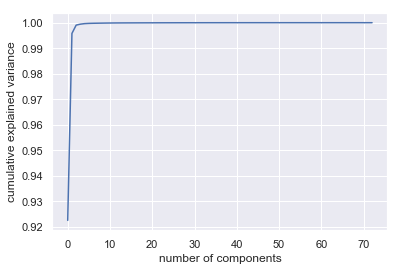

In [68]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [62]:
#rf = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=42)
rf = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=42)
rf.fit(features,targets.values)
#rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

In [63]:

_ = rf.predict(features)
fout = []
for i in range(_.shape[0]):
    fout.append([index[i],targets.values[i],_[i],whites[i],income[i]])
dems = pd.DataFrame.from_records(fout,columns=['FIPS','CURRENT',"PREDICTED",'PERCENT_WHITE','INCOME'])
dems = dems.groupby("FIPS").mean().reset_index()
dems.insert(len(dems.columns), "Difference",dems.PREDICTED - dems.CURRENT)
dems.head()

,FIPS,CURRENT,PREDICTED,PERCENT_WHITE,INCOME,Difference
0,130630402021,55.428571,72.704286,0.062411,29280.0,17.275714
1,130630402022,11.000000,9.988571,0.152789,41250.0,-1.011429
2,130630402032,12.000000,12.964286,0.027087,37681.0,0.964286
3,130630402041,107.714286,101.747143,0.019832,40813.0,-5.967143
4,130630402042,226.428571,225.378571,0.131545,32917.0,-1.050000


In [66]:
dems.FIPS.unique()

array([130630402021, 130630402022, 130630402032, 130630402041,
       130630402042, 130630403021, 130630403022, 130630403023,
       130630403031, 130630403032, 130630403033, 130630403034,
       130630403035, 130630403036, 130630403061, 130630403062,
       130630403081, 130630403083, 130630404071, 130630404072,
       130630404081, 130630404091, 130630404092, 130630404101,
       130630404102, 130630404111, 130630404113, 130630404121,
       130630404122, 130630404131, 130630404141, 130630404151,
       130630404152, 130630404154, 130630404161, 130630404162,
       130630404171, 130630404172, 130630404173, 130630405101,
       130630405102, 130630405122, 130630405133, 130630405151,
       130630405153, 130630405154, 130630405161, 130630405162,
       130630405163, 130630405181, 130630405183, 130630405191,
       130630405192, 130630405203, 130630405211, 130630405212,
       130630405221, 130630405222, 130630405223, 130630405231,
       130630405251, 130630405262, 130630405263, 130630

In [154]:
dems.Difference.describe()
std = dems.Difference.describe()['std']
if 

20.640610554432683

In [125]:
targets.values

array([  43.,   79.,   27., ..., 2612., 3309.,  758.])

In [99]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf, X_train, y_train, cv=10)
scores = scores[scores>0]
display(scores, scores.mean())

array([0.91872412, 0.9210867 , 0.91887627, 0.87480542, 0.87162353,
       0.80326757, 0.69664856, 0.88129167, 0.82673546, 0.92893366])

0.8641992940101613

In [117]:
rf.fit(features,targets)


KeyboardInterrupt: 

In [100]:
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import spearmanr, pearsonr
rf.fit(X_train, y_train)
predicted_test = rf.predict(X_train)
predicted_blind = rf.predict(X_blind)
test_score_blind = r2_score(y_blind, predicted_blind)

print(f'Out-of-bag R-2 score estimate: {rf.oob_score_:>5.3}')
print(f'Test data R-2 score CV: {scores.mean():>5.3}')
print(f'Test data R-2 score Blind Prediction: {test_score_blind:>5.3}')
print('')
print(f'MSE: {round(mean_squared_error(y_train, predicted_test),1)}')
print(f'RMSE: {round(np.sqrt(mean_squared_error(y_train, predicted_test)),1)}')
print('')
print(f'MSE Blind Prediction: {round(mean_squared_error(y_blind, predicted_blind),1)}')
print(f'RMSE Blind Prediction: {round(np.sqrt(mean_squared_error(y_blind, predicted_blind)),1)}')

Out-of-bag R-2 score estimate: 0.889
Test data R-2 score CV: 0.864
Test data R-2 score Blind Prediction: 0.942

MSE: 5205.6
RMSE: 72.1

MSE Blind Prediction: 30071.3
RMSE Blind Prediction: 173.4


In [101]:
overall_scores = {}
overall_scores['Random Forest Regression'] = [('CV_score',scores.mean()),("BLIND_RMSE",test_score_blind)]

In [94]:
importances = rf.feature_importances_
feature_list = list(cols)

In [95]:
var_importances = pd.DataFrame(np.column_stack((cols, importances)))
var_importances = var_importances.sort_values(by=1, ascending=False)
var_importances = var_importances.rename(columns={0: 'Features', 1: 'Importances'})

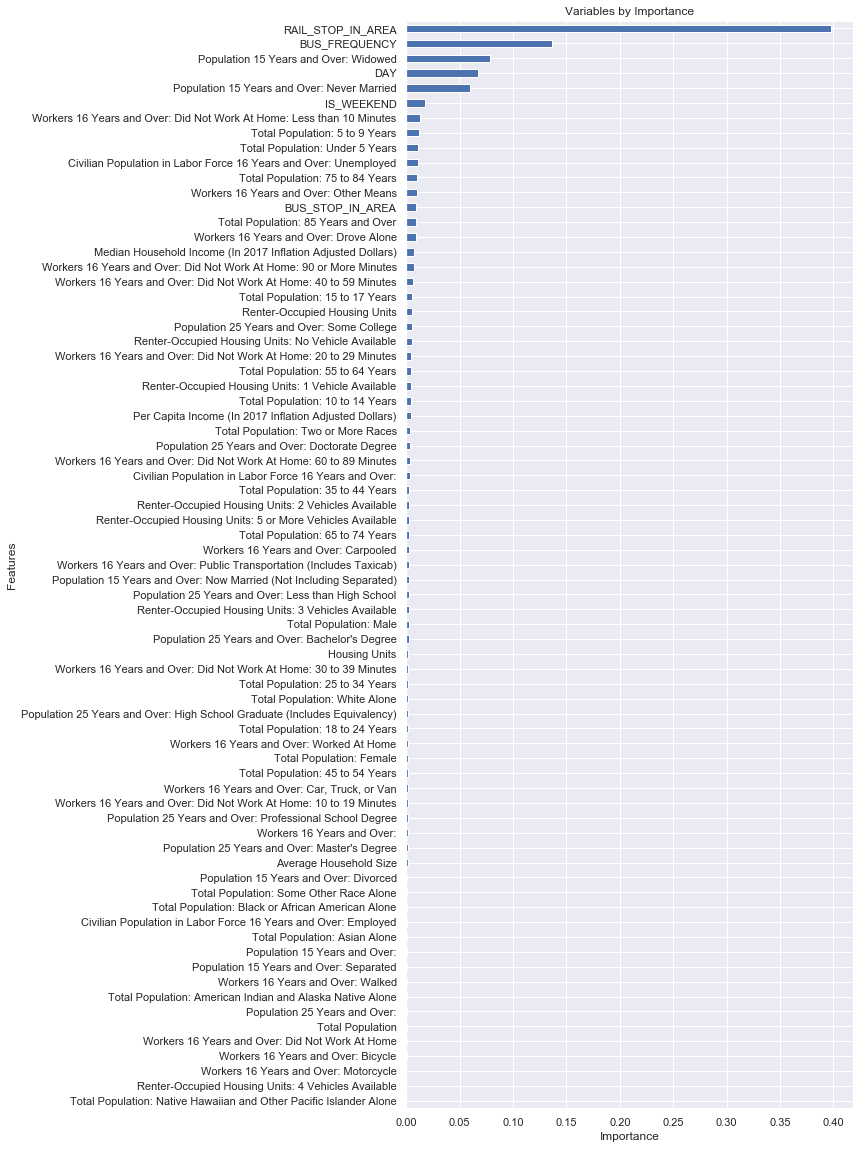

In [96]:
# ax = var_importances.Importances.plot(kind='bar',xticks=var_importances.index, color='b', figsize=(20,8)).set_xticklabels(var_importances.Features) #this is the horizontal version

var_importances.Importances.plot(kind='barh',yticks=var_importances.index, color='b', figsize=(8,20)).set_yticklabels(var_importances.Features);
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Variables by Importance')
plt.gca().invert_yaxis()

## 4.2 - Random Forest: Who are using the stops? (Reduced Dimensionality, selected top 10 features)

In [197]:
top_10 = var_importances.reset_index().iloc[:10,:]
the_rest = var_importances[var_importances.Features.isin(top_10['Features'])==False]
print(f'Variables explain {top_10.Importances.sum()} of data variation.')

Variables explain 0.8085403879914556 of data variation.


In [198]:
features = great_join_typed_noairport.drop(columns=(list(the_rest['Features']) + ['FIPS','RAIL_RIDERS', 'BUS_RIDERS', 'TOTALS', 'PARKNRIDE'])) #for great_join who are using stops
targets = great_join_typed_noairport['TOTALS']

In [77]:
scaler = StandardScaler()
features = scaler.fit_transform(features)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [199]:
X_train, X_blind, y_train, y_blind = train_test_split(features, targets, train_size=0.8, random_state=42) #gets blind data separated
#X_train, X_test, y_train, y_test = train_test_split(X_train_80, y_train_80, train_size=0.8, random_state=42) #train_size=0.8 means 80% of data is for training, 20% for testing

/Users/gideonsetiawan/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [200]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), index=X_train.index.values, columns=X_train.columns.values)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index.values, columns=X_test.columns.values)

/Users/gideonsetiawan/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/gideonsetiawan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
/Users/gideonsetiawan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [201]:
pca = PCA()
pca.fit(X_train)
cpts = pd.DataFrame(pca.transform(X_train))
x_axis = np.arange(1, pca.n_components_+1)
pca_scaled = PCA()
pca_scaled.fit(X_train_scaled)
cpts_scaled = pd.DataFrame(pca.transform(X_train_scaled))

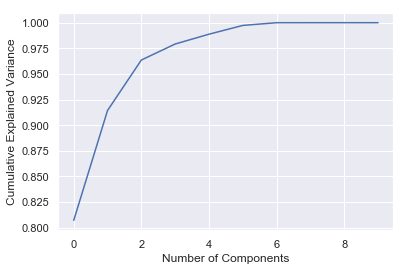

In [202]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance');

In [203]:
rf = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

In [204]:
scores = cross_val_score(rf, X_train, y_train, cv=10)

In [205]:
scores = scores[scores>0]
display(scores, scores.mean())

array([0.81804065, 0.88628793, 0.83631087, 0.51970494, 0.88121793,
       0.86716637, 0.91184671, 0.82091747, 0.89130134, 0.63528321])

0.8068077408399047

In [206]:
predicted_test = rf.predict(X_test)
predicted_blind = rf.predict(X_blind)
test_score_blind = r2_score(y_blind, predicted_blind)

print(f'Out-of-bag R-2 score estimate: {rf.oob_score_:>5.3}')
print(f'Test data R-2 score CV: {scores.mean():>5.3}')
print(f'Test data R-2 score Blind Prediction: {test_score_blind:>5.3}')
print('')
print(f'MSE: {round(mean_squared_error(y_test, predicted_test),1)}')
print(f'RMSE: {round(np.sqrt(mean_squared_error(y_test, predicted_test)),1)}')
print('')
print(f'MSE Blind Prediction: {round(mean_squared_error(y_blind, predicted_blind),1)}')
print(f'RMSE Blind Prediction: {round(np.sqrt(mean_squared_error(y_blind, predicted_blind)),1)}')

Out-of-bag R-2 score estimate: 0.866
Test data R-2 score CV: 0.807
Test data R-2 score Blind Prediction: 0.919

MSE: 47980.8
RMSE: 219.0

MSE Blind Prediction: 42442.3
RMSE Blind Prediction: 206.0


In [207]:
importances = rf.feature_importances_
feature_list = list(features.columns)

In [208]:
var_importances = pd.DataFrame(np.column_stack((features.columns, importances)))
var_importances = var_importances.sort_values(by=1, ascending=False)
var_importances = var_importances.rename(columns={0: 'Features', 1: 'Importances'})

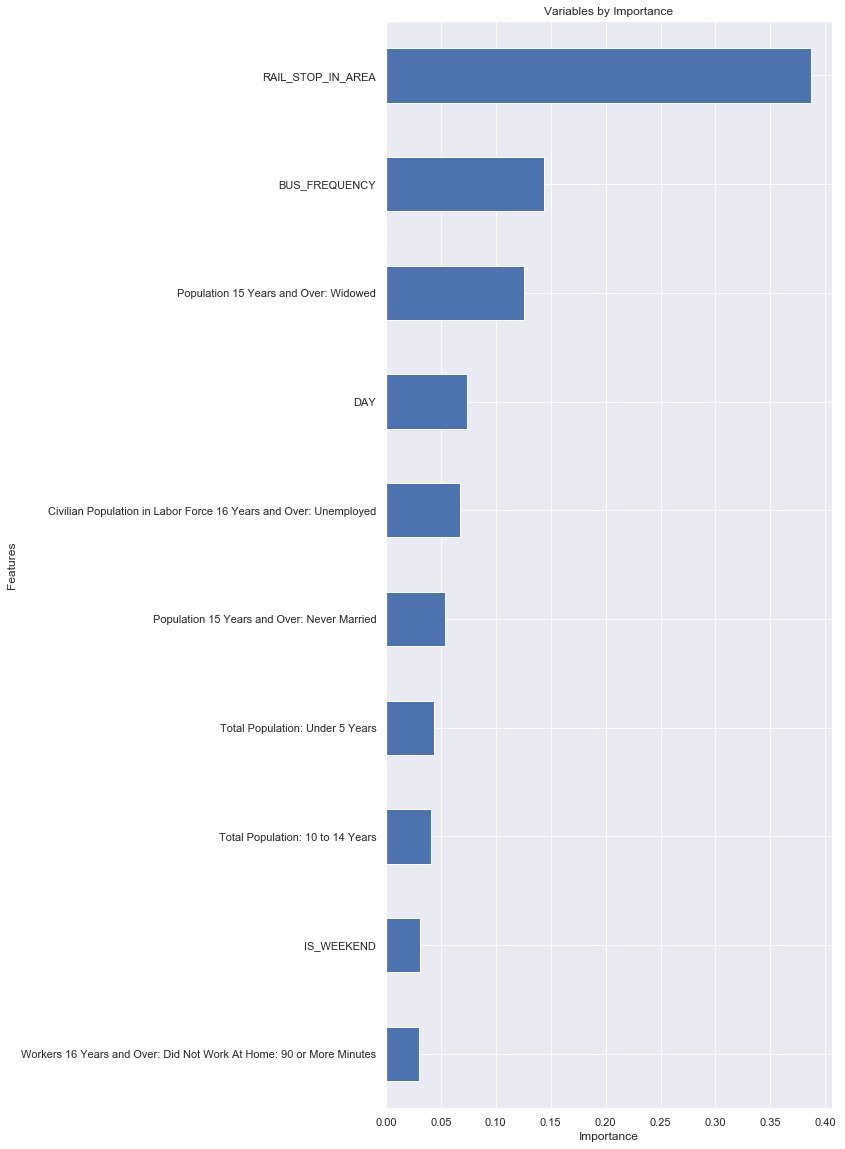

In [209]:
# ax = var_importances.Importances.plot(kind='bar',xticks=var_importances.index, color='b', figsize=(20,8)).set_xticklabels(var_importances.Features) #this is the horizontal version

var_importances.Importances.plot(kind='barh',yticks=var_importances.index, color='b', figsize=(8,20)).set_yticklabels(var_importances.Features);
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Variables by Importance')
plt.gca().invert_yaxis()

## 4.3 - Lasso and Ridge Regression: Who are using the stops? (Reduced Dimensionality based on model above)

In [111]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso, LinearRegression

ridge = Ridge()
lasso = Lasso()
linreg = LinearRegression()
parameters = {'alpha': [1e-7,1e-3, 1e-2, 1, 5, 10, 20, 40, 1000]}

ridge_regressor = GridSearchCV(ridge, parameters, cv=10)

overall_scores['RIDGE REGRESSOR'] = [("CV_R2",cross_val_score(ridge_regressor, X_train, y_train, cv=10).mean())]
ridge_regressor.fit(X_train, y_train)
overall_scores['RIDGE REGRESSOR'].append(("Blind_R2",r2_score(y_blind,ridge_regressor.predict(X_blind))))

#lasso_regressor = GridSearchCV(lasso, parameters, cv=10)
#overall_scores['RIDGE REGRESSOR'] = [("CV_R2",cross_val_score(lasso_regressor, X_train, y_train, cv=10).mean())]
#lasso_regressor.fit(X_train, y_train)

linreg_scores = cross_val_score(linreg, X_train, y_train, cv=10)
overall_scores['Linear Regression'] = [('CV_R2',linreg_scores.mean())]

linreg.fit(X_train, y_train)
overall_scores['Linear Regression'].append(("Blind_R2",r2_score(y_blind,linreg.predict(X_blind))))
print(overall_scores)

{'Random Forest Regression': [('CV_score', 0.8641992940101613), ('BLIND_RMSE', 0.9424952454785974)], 'RIDGE REGRESSOR': [('CV_R2', 0.4047951376547451), ('Blind_R2', 0.44830028007835365)], 'Linear Regression': [('CV_R2', 0.3959708197642086), ('Blind_R2', 0.4867042002922244)]}


In [112]:
with open("ML_RESULTS.csv",'w') as fout:
    import csv
    writer = csv.writer(fout)
    for model,alist in overall_scores.items():
        for score in alist:
            writer.writerow([model,score[0],score[1]])

In [166]:
print('Linear Regression Model Scores')
print('')
print(f'r2 CV: {round(linreg_scores.mean(),3)}')
print(f'r2 Blind Prediction: {round(r2_score(y_blind, linreg.predict(X_blind)),3)}')
print('')
print(f'MSE Blind Prediction: {round(mean_squared_error(y_blind, linreg.predict(X_blind)),1)}')
print(f'RMSE Blind Prediction: {round(np.sqrt(mean_squared_error(y_blind, linreg.predict(X_blind))),1)}')

Linear Regression Model Scores

r2 CV: 0.344
r2 Blind Prediction: 0.443

MSE Blind Prediction: 236316.7
RMSE Blind Prediction: 486.1


In [167]:
print('Ridge Regression Model Scores')
print('')
print(f'r2 Blind Prediction: {round(r2_score(y_blind, ridge_regressor.predict(X_blind)),3)}')
print('')
print(f'MSE: {round(ridge_regressor.best_score_*(-1),1)}')
print(f'RMSE: {round(np.sqrt(ridge_regressor.best_score_*(-1)),1)}')
print('')
print(f'MSE Blind Prediction: {round(mean_squared_error(y_blind, ridge_regressor.predict(X_blind)),1)}')
print(f'RMSE Blind Prediction: {round(np.sqrt(mean_squared_error(y_blind, ridge_regressor.predict(X_blind))),1)}')

Ridge Regression Model Scores

r2 Blind Prediction: 0.442

MSE: 167930.0
RMSE: 409.8

MSE Blind Prediction: 236550.9
RMSE Blind Prediction: 486.4


In [168]:
print('Lasso Regression Model Scores')
print('')
print(f'r2 Blind Prediction: {round(r2_score(y_blind, lasso_regressor.predict(X_blind)),3)}')
print('')
print(f'MSE: {round(lasso_regressor.best_score_*(-1),1)}')
print(f'RMSE: {round(np.sqrt(lasso_regressor.best_score_*(-1)),1)}')
print('')
print(f'MSE Blind Prediction: {round(mean_squared_error(y_blind, lasso_regressor.predict(X_blind)),1)}')
print(f'RMSE Blind Prediction: {round(np.sqrt(mean_squared_error(y_blind, lasso_regressor.predict(X_blind))),1)}')

Lasso Regression Model Scores

r2 Blind Prediction: 0.443

MSE: 167937.9
RMSE: 409.8

MSE Blind Prediction: 236316.7
RMSE Blind Prediction: 486.1


## 4.4 - Random Forest: Where are people going? (All Features)

In [ ]:
features1 = great_join_1.drop(columns=['GEOID','ZIPCODE', 'COUNT','DURATION','DAY']) #for great_join who are using stops
targets1 = great_join_1['COUNT']

In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(features1, targets1, train_size=0.8, random_state=42) #train_size=0.8 means 80% of data is for training, 20% for testing
scaler1 = StandardScaler().fit(X_train1)
# X_train_scaled1 = pd.DataFrame(scaler.transform(X_train1), index=X_train1.index.values, columns=X_train1.columns.values)
# X_test_scaled1 = pd.DataFrame(scaler.transform(X_test1), index=X_test1.index.values, columns=X_test1.columns.values)

In [ ]:
rf1 = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=42)
rf1.fit(X_train1, y_train1)

In [ ]:
from sklearn.model_selection import cross_val_score
scores1 = cross_val_score(rf1, X_train1, y_train1, cv=10)

In [ ]:
display(scores1, scores1.mean())

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import spearmanr, pearsonr

predicted_train = rf1.predict(X_train1)
predicted_test = rf1.predict(X_test1)
test_score = r2_score(y_test1, predicted_test)
spearman = spearmanr(y_test1, predicted_test)
pearson = pearsonr(y_test1, predicted_test)

print(f'Out-of-bag R-2 score estimate: {rf.oob_score_:>5.3}')
print(f'Test data R-2 score: {test_score:>5.3}')
print(f'Test data Spearman correlation: {spearman[0]:.3}')
print(f'Test data Pearson correlation: {pearson[0]:.3}')
print(f'Mean Squared Error: {mean_squared_error(y_test1, predicted_test)}')
print(f'Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test1, predicted_test))}')

In [ ]:
importances1 = rf1.feature_importances_
feature_list1 = list(features1.columns)

In [ ]:
var_importances1 = pd.DataFrame(np.column_stack((features1.columns, importances1)))
var_importances1 = var_importances1.sort_values(by=1, ascending=False)
var_importances1 = var_importances1.rename(columns={0: 'Features', 1: 'Importances'})

In [ ]:
# ax = var_importances.Importances.plot(kind='bar',xticks=var_importances.index, color='b', figsize=(20,8)).set_xticklabels(var_importances.Features) #this is the horizontal version

var_importances1.Importances.plot(kind='barh',yticks=var_importances1.index, color='b', figsize=(8,20)).set_yticklabels(var_importances1.Features);
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Variables by Importance')
plt.gca().invert_yaxis()

## 4.4 - Random Forest: Where are people going? (Reduced Dimensionality, selected top 10 features)

In [ ]:
new = great_join_1[list(var_importances1.reset_index(drop=True).iloc[0:9,:]['Features'])+['COUNT']]

In [ ]:
great_join.head()

In [ ]:
features1 = new.drop(columns=['COUNT']) #for great_join who are using stops
targets1 = new['COUNT']

In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(features1, targets1, train_size=0.8, random_state=42) #train_size=0.8 means 80% of data is for training, 20% for testing
scaler1 = StandardScaler().fit(X_train1)
# X_train_scaled1 = pd.DataFrame(scaler.transform(X_train1), index=X_train1.index.values, columns=X_train1.columns.values)
# X_test_scaled1 = pd.DataFrame(scaler.transform(X_test1), index=X_test1.index.values, columns=X_test1.columns.values)

In [ ]:
rf1 = RandomForestRegressor(n_estimators=500, oob_score=True, random_state=42)
rf1.fit(X_train1, y_train1)

In [ ]:
from sklearn.model_selection import cross_val_score
scores1 = cross_val_score(rf1, X_train1, y_train1, cv=10)

In [ ]:
display(scores1, scores1.mean())

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import spearmanr, pearsonr

predicted_train = rf1.predict(X_train1)
predicted_test = rf1.predict(X_test1)
test_score = r2_score(y_test1, predicted_test)
spearman = spearmanr(y_test1, predicted_test)
pearson = pearsonr(y_test1, predicted_test)

print(f'Out-of-bag R-2 score estimate: {rf.oob_score_:>5.3}')
print(f'Test data R-2 score: {test_score:>5.3}')
print(f'Test data Spearman correlation: {spearman[0]:.3}')
print(f'Test data Pearson correlation: {pearson[0]:.3}')
print(f'Mean Squared Error: {mean_squared_error(y_test1, predicted_test)}')
print(f'Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test1, predicted_test))}')

In [ ]:
importances1 = rf1.feature_importances_
feature_list1 = list(features1.columns)

In [ ]:
var_importances = pd.DataFrame(np.column_stack((features1.columns, importances1)))
var_importances = var_importances.sort_values(by=1, ascending=False)
var_importances = var_importances.rename(columns={0: 'Features', 1: 'Importances'})

In [ ]:
# ax = var_importances.Importances.plot(kind='bar',xticks=var_importances.index, color='b', figsize=(20,8)).set_xticklabels(var_importances.Features) #this is the horizontal version

var_importances.Importances.plot(kind='barh',yticks=var_importances.index, color='b', figsize=(8,20)).set_yticklabels(var_importances.Features);
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Variables by Importance')
plt.gca().invert_yaxis()

# 5. Hypothetical Route Use Case (could only be used with model with complete features)

In [211]:
new_route = pd.read_csv('hypothetical_route.csv')
new_route.head()

,GEOID,NUMPOINTS
0,131210101133,3
1,131210101151,3
2,131210101141,1
3,131210101131,2
4,131210102123,3


In [212]:
nr_weekday = great_join_typed[great_join_typed.FIPS.isin(new_route.GEOID)&(great_join_typed.IS_WEEKEND==0)]
nr_weekend = great_join_typed[great_join_typed.FIPS.isin(new_route.GEOID)&(great_join_typed.IS_WEEKEND==1)]

In [215]:
nr_weekday.drop(columns=['FIPS','RAIL_RIDERS', 'BUS_RIDERS', 'TOTALS','DAY']);

In [ ]:
before = rf.predict(nr_weekday.drop(columns=['FIPS','RAIL_RIDERS', 'BUS_RIDERS', 'TOTALS','DAY']))
before = nr_weekday['TOTALS']

In [ ]:
def additional_frequency(headway, operational_hours, bidirectional=True): #headway is in minutes, operational_hours is in hours
    if bidirectional == True:
        bidirectional = 2
    else:
        bidirectional = 1
    additional_frequency = ((operational_hours*60)//headway)*bidirectional
    return additional_frequency

In [ ]:
b_f_before = nr_weekday.BUS_FREQUENCY.sum()
nr_weekday['BUS_FREQUENCY'] = nr_weekday['BUS_FREQUENCY'] + additional_frequency(20,19) #20 minut headway, 19 hour operational time
b_f_after = nr_weekday.BUS_FREQUENCY.sum()
bus_freq_increase = 100*((b_f_after.sum() - b_f_before.sum())/b_f_before.sum())
print(bus_freq_increase)

In [ ]:
after = rf.predict(nr_weekday.drop(columns=['FIPS','RAIL_RIDERS', 'BUS_RIDERS', 'TOTALS','DAY']))
after = np.round(after)

In [ ]:
nr_weekday['TOTALS'].sum()

In [ ]:
before.sum()

In [ ]:
after.sum()

In [ ]:
pct_ridership_change = 100*((after.sum() - before.sum())/before.sum())
print(pct_ridership_change)

In [ ]:
ridership_change = pd.DataFrame(np.column_stack((nr_weekday.FIPS,before, after)), columns=['GEOID','ACTUAL','PREDICTED']).astype({'GEOID': int, 'ACTUAL': 'int', 'PREDICTED': int}).groupby('GEOID')[['ACTUAL','PREDICTED']].sum().reset_index()
ridership_change['PERCENT_CHANGE'] = ((ridership_change['PREDICTED'] - ridership_change['ACTUAL'])/ridership_change['ACTUAL']).round(3)*100

name = %pwd
name = name + '/' + 'ridership_change.csv'
ridership_change.to_csv(name, index=False)

# 6. Export to File

In [ ]:
predicted_all = rf.predict(np.array(features))

In [ ]:
great_join_typed.head()

In [ ]:
comparison = pd.DataFrame(np.stack((great_join_typed[['FIPS','DAY']],predicted_all, targets),axis=1))
comparison = comparison.rename(columns={0:'GEOID', 1:'DAY', 2:'Predicted',3:'Actual'})
comparison = comparison.astype({'GEOID': int}) #casts GEOID into integer type
comparison['Difference'] = comparison['Predicted'] - comparison['Actual'] #finds the difference between actual and predicted values
comparison = comparison.groupby('GEOID')[['Predicted', 'Actual', 'Difference']].mean()
comparison['Standardized'] = comparison['Difference']/comparison['Actual'] #finds the percentage difference
comparison = comparison.replace([np.inf, -np.inf], np.nan)

In [ ]:
display(comparison.sort_values(by='Predicted', ascending=False).head(), comparison.shape)

In [ ]:
name = %pwd
name = name + '/' + 'comparison.csv'
comparison.to_csv(name, index=True)

name = %pwd
name = name + '/' + 'importances.csv'
var_importances.to_csv(name, index=True)